#### Maps of surface precipitation in prognostic runs for baseline physics, RF, and NN ensemble

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt

import os
import cftime
import intake
import fsspec
import numpy as np
import pandas as pd
import seaborn as sb
import xarray as xr
import json
import copy

import fv3viz as viz
from vcm.catalog import catalog
from vcm.fv3.metadata import standardize_fv3_diagnostics

def weighted_average(array, weights, axis=None):
    return np.nansum(array * weights, axis=axis) / np.nansum(weights, axis=axis)


MAPPABLE_VAR_KWARGS = {
    "coord_x_center": "x",
    "coord_y_center": "y",
    "coord_x_outer": "x_interface",
    "coord_y_outer": "y_interface",
    "coord_vars": {
        "lonb": ["y_interface", "x_interface", "tile"],
        "latb": ["y_interface", "x_interface", "tile"],
        "lon": ["y", "x", "tile"],
        "lat": ["y", "x", "tile"],
    },
}

SECONDS_PER_DAY = 86400


In [2]:
def get_prog_run_precip_bias(
        diags_path,
        verif_precip,
        var="total_precipitation_rate", 
        start_time=cftime.DatetimeJulian(2016, 8, 11, 0, 0, 0, 0)
):
    ds = intake.open_zarr(diags_path).to_dask().sortby("time")
    verif_precip = verif_precip.sortby("time")
    prog_times = ds.sel(time=slice(start_time, None)).time.values
    verif_times = verif_precip.sortby("time")
    verif_times = verif_times.sel(time=slice(start_time, None)).time.values
    overlap_times = sorted(list(set(verif_times).intersection(prog_times)))
    
    da_verif = verif_precip.sortby("time")[var].sel(time=overlap_times)
    ds = ds.sortby("time").sel(time=overlap_times)
    ds["total_precip_to_surface_time_mean_bias"] = (ds["total_precipitation_rate"] - da_verif) * SECONDS_PER_DAY 
    return ds[["total_precip_to_surface_time_mean_bias"]].mean("time").load()

def concat_ics(ic_paths, start_datetimes, ic_coord, verif_physics):
    ic_data = []
    for path, start_datetime in zip(ic_paths, start_datetimes):
        ds = get_prog_run_precip_bias(
                os.path.join(path, "diags.zarr"),
                verif_physics,
                start_time=start_datetime
        )
        
        ic_data.append(ds)
    
    return xr.concat(ic_data, dim=pd.Index(ic_coord, name="ic"))

In [3]:
   
grid = catalog["grid/c48"].read()
area = grid["area"]

land_sea_mask = catalog["landseamask/c48"].read()["land_sea_mask"]

verif_physics = standardize_fv3_diagnostics(catalog['40day_c48_gfsphysics_15min_may2020'].to_dask())
verif_physics["total_precipitation_rate"] = verif_physics["PRATEsfc"]

In [4]:
ics = ["20160805.000000", "20160805.000000", "20160805.000000", "20160805.000000"]

baseline_ics = [f"gs://vcm-ml-experiments/2021-04-13/baseline-physics-run-201608{start_day}-start-rad-step-1800s" for start_day in ["05", "13", "21", "29"]]
nn_ics = [f"gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/initial_conditions_runs_rectified_nn_rad/{ic}" for ic in ics]
rf_ics = ["gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/initial_conditions_runs/{ic}" for ic in ics]
control_nudging_tq_rf_ics = [f"gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/control-rf/prognostic_run_tendencies_only_ics/{ic}" for ic in ics]


In [15]:
nn_precip_bias = get_prog_run_precip_bias(
        "gs://vcm-ml-experiments/2021-06-21-nudge-to-c3072-dq1-dq2-only/nn-ensemble-model/initial_conditions_runs/20160805.000000/diags.zarr",
        verif_physics
)
rf_precip_bias = get_prog_run_precip_bias(
        "gs://vcm-ml-experiments/2021-06-21-nudge-to-c3072-dq1-dq2-only/rf/initial_conditions_runs/20160805.000000/diags.zarr",
        verif_physics
)
baseline_precip_bias = get_prog_run_precip_bias(
        "gs://vcm-ml-experiments/2021-04-13/baseline-physics-run-20160805-start-rad-step-1800s/diags.zarr",
        verif_physics
)

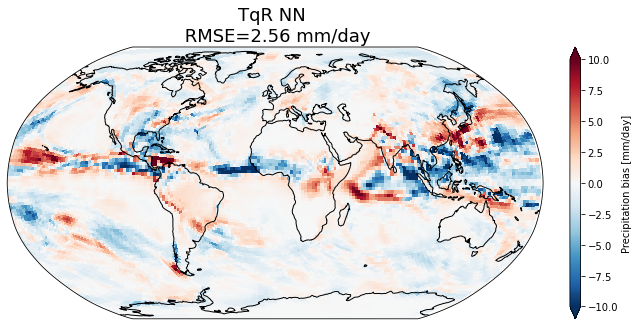

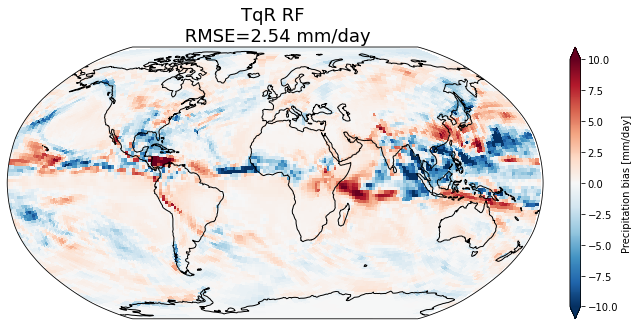

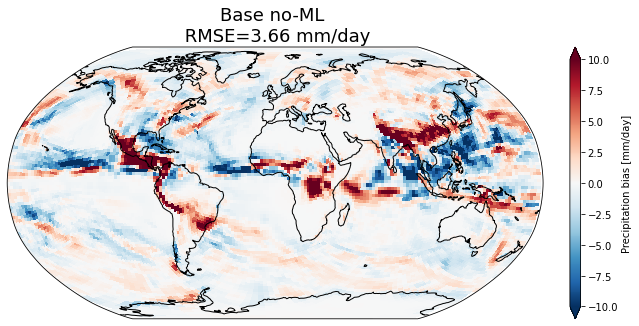

In [16]:
sb.reset_orig()
    
var = "total_precip_to_surface_time_mean_bias"
vmax = 10
fig_size = (12,5)

labels = ["TqR NN", "TqR RF", "Base no-ML"]
datasets = [nn_precip_bias, rf_precip_bias, baseline_precip_bias]

for label, ds in zip(labels, datasets):
    mappable_var = viz.mappable_var(ds.merge(grid), var, **MAPPABLE_VAR_KWARGS)
    
    rmse = np.sqrt(weighted_average(ds[var]**2, area))
    bias = weighted_average(ds[var], area)
    
    fig, _, _, _, _ = viz.plot_cube(
        mappable_var,
        vmax=vmax,
        cbar_label="Precipitation bias [mm/day]",
    )
    
    fig.set_size_inches(fig_size)
    
    title = f"{label} \n RMSE={rmse:3.2f} mm/day"
    plt.title(title, fontsize=18)
    plt.savefig(f"figures/prognostic_sfc_precip_rmse_map_{label.replace(' ', '_').lower()}.png", bbox_inches = "tight", dpi=500)
    plt.show()
    

Old notebook loaded the prognostic report diags, which precomputed average over entire run

#### Bar plot for domain averages of precip bias and RMSE

In [17]:
var= "total_precip_to_surface_time_mean_bias"

domain_avg_biases = []

#labels = ["Baseline physics", "Random forest", "Neural network ensemble" ]
labels = ["Base no-ML", "TqR RF", "TqR NN"]

#datasets = [diags_baseline, diags_rf, diags_nn, ]
datasets = [baseline_precip_bias, rf_precip_bias, nn_precip_bias]
for domain in ["global", "land", "ocean"]:
    for label, ds in zip(labels, datasets):
        if domain == "global":
            area_masked = area
            da = ds[var]
        elif domain == "land":
            area_masked = area.where(land_sea_mask==1)
            da = ds[var].where(land_sea_mask==1)
        elif domain == "ocean":
            area_masked = area.where(land_sea_mask==0)
            da = ds[var].where(land_sea_mask==0)            
        bias = ((da * area_masked).sum(skipna=True, dim=["tile", "x", "y"]) / area_masked.sum(skipna=True)).values.item()
        rmse = np.sqrt( 
            (da**2 * area_masked).sum(skipna=True, dim=["tile", "x", "y"]) / area_masked.sum(skipna=True)
        ).values.item()        
        domain_avg_biases.append([domain, label, rmse, bias])
        
biases = pd.DataFrame(domain_avg_biases, columns=["domain", "dataset", "RMSE", "bias"])


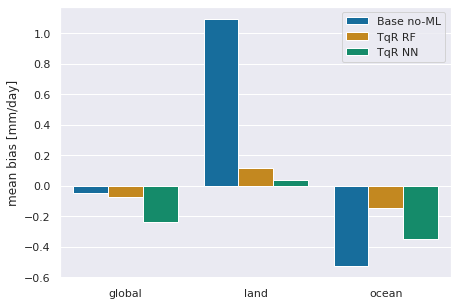

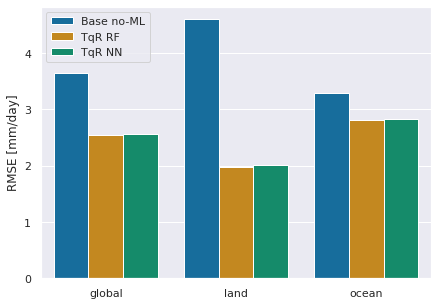

In [20]:
colors = sb.color_palette('colorblind')
sb.set(font_scale = 1)
figsize=(7,5)

biases = pd.DataFrame(domain_avg_biases, columns=["domain", "dataset", "RMSE", "bias"])

#nn_land_bias = biases \
#    .loc[biases['domain'] == "land"] \
#    .loc[biases["dataset"] == "TqR NN"] \
#    ["bias"].item()


fig = plt.figure(figsize=figsize)
f = sb.barplot(
    x="domain", 
    y="bias", 
    hue="dataset", 
    data=biases,
    palette=colors
)
f.set_xlabel("", fontsize=20)
f.set_ylabel("mean bias [mm/day]")
f.legend(loc="upper right")
#plt.plot([1.25,],[nn_land_bias], 'o', color=colors[2])
fig.savefig(f"figures/prognostic_sfc_precip_bias_bar_plot.png")


fig = plt.figure(figsize=figsize)
f = sb.barplot(
    x="domain", 
    y="RMSE", 
    hue="dataset", 
    data=biases,
    palette=colors,
)
f.set_xlabel("", fontsize=20)
f.set_ylabel("RMSE [mm/day]")
f.legend(loc="upper left")
fig.savefig(f"figures/prognostic_sfc_precip_rmse_bar_plot.png")

Combine subfigures

<Figure size 432x288 with 0 Axes>

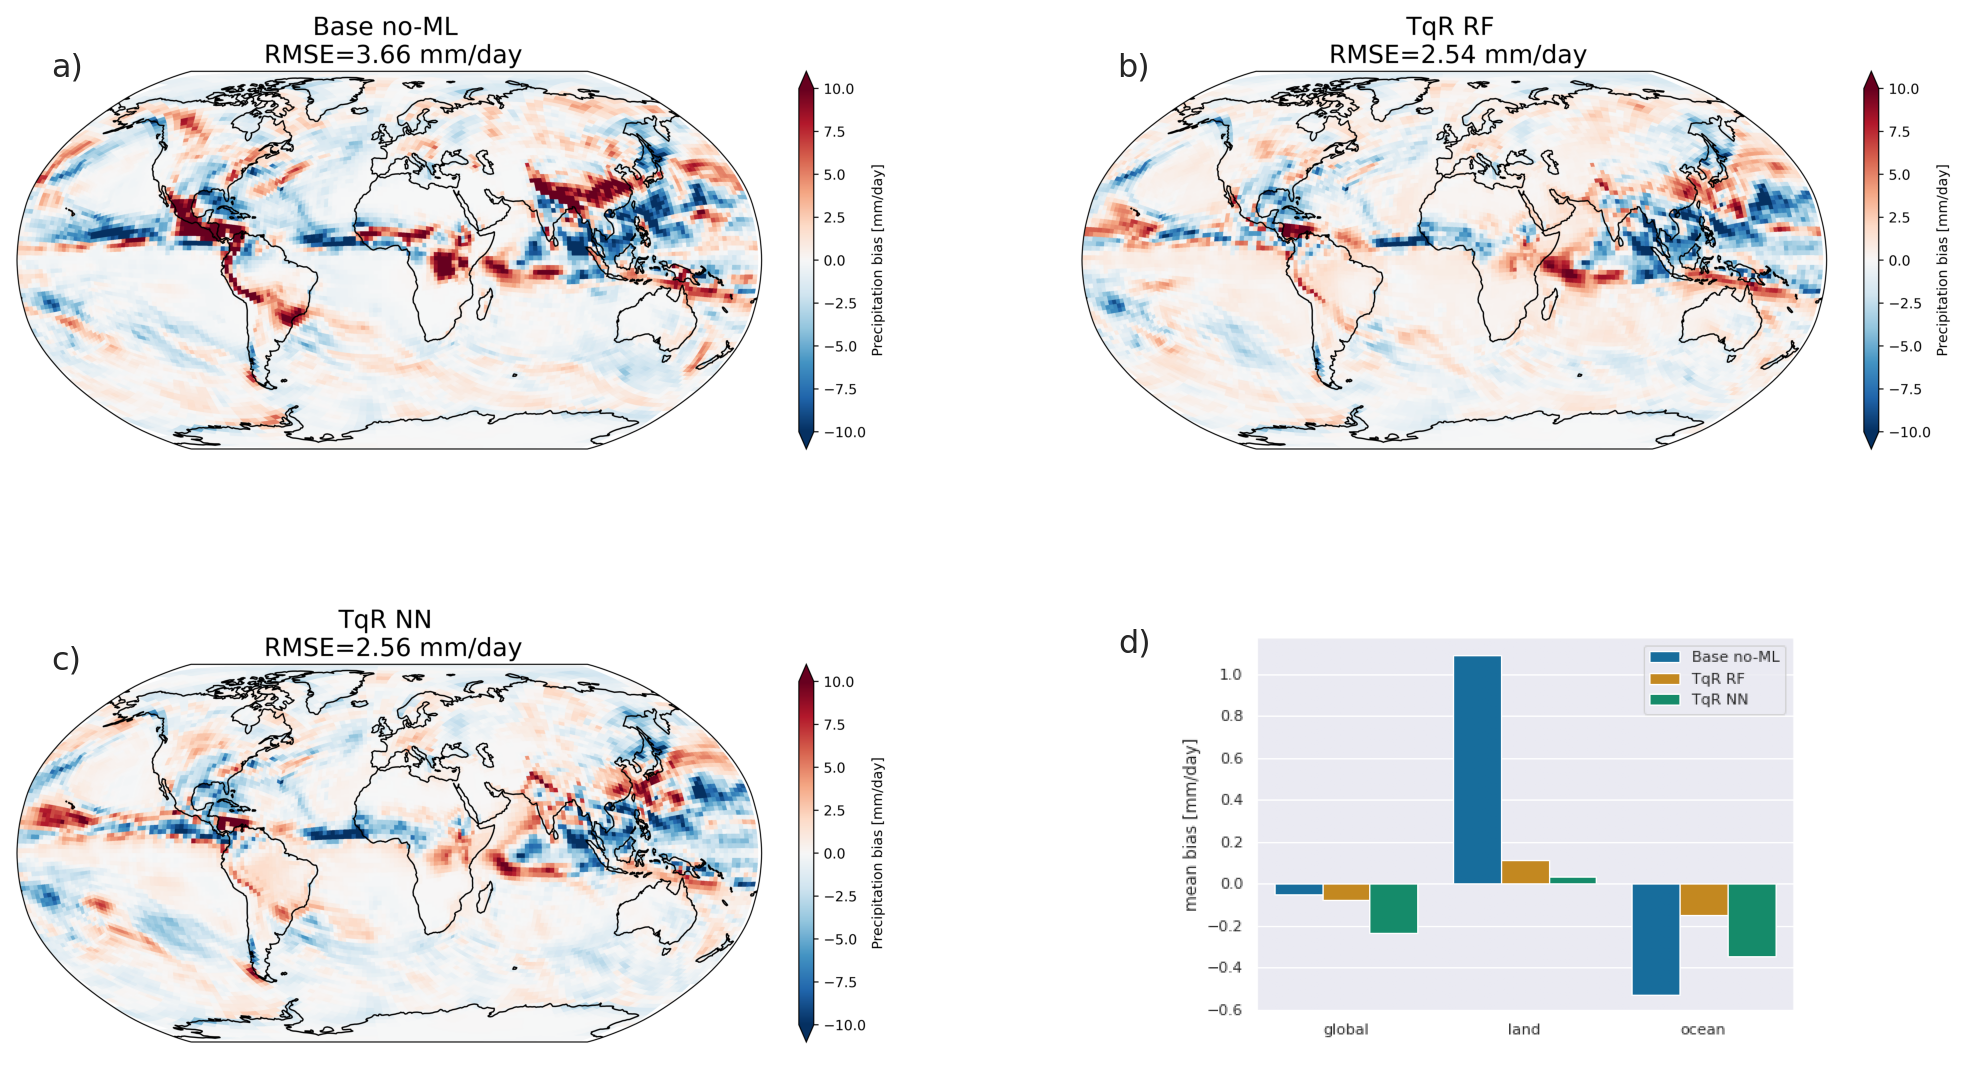

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


baseline = mpimg.imread("figures/prognostic_sfc_precip_rmse_map_base_no-ml.png")
rf = mpimg.imread("figures/prognostic_sfc_precip_rmse_map_tqr_rf.png")
nn = mpimg.imread("figures/prognostic_sfc_precip_rmse_map_tqr_nn.png")
bar = mpimg.imread("figures/prognostic_sfc_precip_bias_bar_plot.png")
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,2, figsize=(35,20)) 
plt.axis('off')

axarr[0][0].imshow(baseline)
axarr[0][0].set_axis_off()
axarr[0][0].text(0.05, 0.9, "a)", va='top', fontsize=32, transform=axarr[0][0].transAxes)

axarr[0][1].imshow(rf)
axarr[0][1].set_axis_off()
axarr[0][1].text(0.05, 0.9, "b)", va='top', fontsize=32, transform=axarr[0][1].transAxes)

axarr[1][0].imshow(nn)
axarr[1][0].set_axis_off()
axarr[1][0].text(0.05, 0.9, "c)", va='top', fontsize=32, transform=axarr[1][0].transAxes)


axarr[1][1].imshow(bar)
axarr[1][1].set_axis_off()
axarr[1][1].text(-0.075, 0.9, "d)", va='top', fontsize=32, transform=axarr[1][1].transAxes)

plt.savefig("final_figures/PrecBiasMaps.eps", format="eps")

#### Save table of IC ensemble mean and std for ablation study

In [24]:
ics = ["20160805.000000", "20160813.000000", "20160821.000000", "20160829.000000"]
start_datetimes = [cftime.DatetimeJulian(2016, 8, day, 0, 0, 0, 0) for day in [11, 19, 27,]] + [cftime.DatetimeJulian(2016, 9, 4, 0, 0, 0, 0)]

baseline_no_ML_paths = [f"gs://vcm-ml-experiments/2021-04-13/baseline-physics-run-201608{start_day}-start-rad-step-1800s" for start_day in ["05", "13", "21", "29"]]
temperature_moisture_RF_paths = [f"gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/control-dq1-dq2-rf/initial_conditions_runs/{ic}" for ic in ics] 
temperature_moisture_winds_RF_paths = [f"gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/control-rf/prognostic_run_tendencies_only_ics/{ic}" for ic in ics]
temperature_moisture_winds_prescribed_sfc_RF_paths = [f"gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/initial_conditions_runs/{ic}" for ic in ics]
temperature_moisture_winds_prescribed_sfc_NN_ensemble_paths = [f"gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/initial_conditions_runs_rectified_nn_rad/{ic}" for ic in ics]

temperature_moisture_prescribed_sfc_RF_paths = [f"gs://vcm-ml-experiments/2021-06-21-nudge-to-c3072-dq1-dq2-only/rf/initial_conditions_runs/{ic}" for ic in ics]
temperature_moisture_prescribed_sfc_NN_ensemble_paths = [f"gs://vcm-ml-experiments/2021-06-21-nudge-to-c3072-dq1-dq2-only/nn-ensemble-model/initial_conditions_runs/{ic}" for ic in ics]



In [25]:
args = [start_datetimes, ics, verif_physics]

baseline_no_ML = concat_ics(baseline_no_ML_paths, *args)
temperature_moisture_RF = concat_ics(temperature_moisture_RF_paths, *args)
temperature_moisture_winds_RF = concat_ics(temperature_moisture_winds_RF_paths, *args)
temperature_moisture_winds_prescribed_sfc_RF = concat_ics(temperature_moisture_winds_prescribed_sfc_RF_paths, *args)
temperature_moisture_winds_prescribed_sfc_NN_ensemble = concat_ics(temperature_moisture_winds_prescribed_sfc_NN_ensemble_paths, *args)

temperature_moisture_prescribed_sfc_RF  = concat_ics(temperature_moisture_prescribed_sfc_RF_paths, *args)
temperature_moisture_prescribed_sfc_NN_ensemble = concat_ics(temperature_moisture_prescribed_sfc_NN_ensemble_paths, *args)

In [28]:
var= "total_precip_to_surface_time_mean_bias"

domain_avg_biases = []

labels = [
    "base-no-ML",
    "Tq-RF",
    "Tquv-RF",
    "TquvR-RF",
    "TquvR-NN",
    "TqR-RF",
    "TqR-NN",
]

datasets = [
    baseline_no_ML,
    temperature_moisture_RF, 
    temperature_moisture_winds_RF,
    temperature_moisture_winds_prescribed_sfc_RF, 
    temperature_moisture_winds_prescribed_sfc_NN_ensemble,
    temperature_moisture_prescribed_sfc_RF ,
    temperature_moisture_prescribed_sfc_NN_ensemble
]
for domain in ["global", "land", "ocean"]:
    for label, ds_ in zip(labels, datasets):
        for ic in ics:
            ds = copy.copy(ds_).sel(ic=ic)
            if domain == "global":
                area_masked = area
                da = ds[var]
            elif domain == "land":
                area_masked = area.where(land_sea_mask==1)
                da = ds[var].where(land_sea_mask==1)
            elif domain == "ocean":
                area_masked = area.where(land_sea_mask==0)
                da = ds[var].where(land_sea_mask==0)     
            bias = ((da * area_masked).sum(skipna=True, dim=["tile", "x", "y"]) / area_masked.sum(skipna=True)).values.item()
            rmse = np.sqrt( 
                (da**2 * area_masked).sum(skipna=True, dim=["tile", "x", "y"]) / area_masked.sum(skipna=True)
            ).values.item()        
            domain_avg_biases.append([ic, domain, label, rmse, bias,])

df = pd.DataFrame(domain_avg_biases, columns=["IC", "domain", "dataset", "RMSE", "bias"])

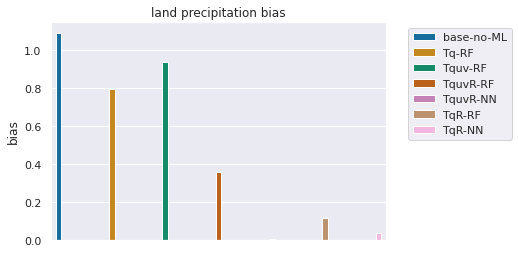

In [29]:
df.loc[df["domain"]=="land"]

fig = sb.barplot(
    x="dataset", 
    y="bias", 
    hue="dataset", 
    data=df.loc[df["domain"]=="land"].loc[df["IC"]=="20160805.000000"],
    palette=colors
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', )
plt.title("land precipitation bias")
fig.axes.get_xaxis().set_visible(False)

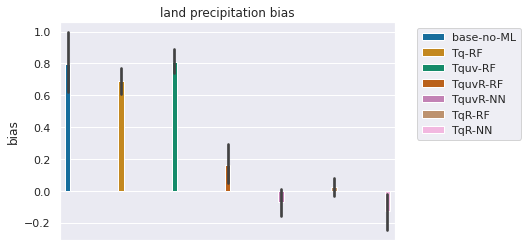

In [30]:
df.loc[df["domain"]=="land"]

fig = sb.barplot(
    x="dataset", 
    y="bias", 
    hue="dataset", 
    data=df.loc[df["domain"]=="land"],
    palette=colors
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', )
plt.title("land precipitation bias")
fig.axes.get_xaxis().set_visible(False)

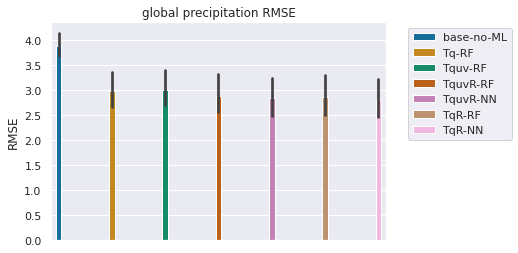

In [31]:

fig = sb.barplot(
    x="dataset", 
    y="RMSE", 
    hue="dataset", 
    data=df.loc[df["domain"]=="global"], #.loc[df["IC"]=="20160805.000000"],
    palette=colors
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', )
plt.title("global precipitation RMSE")
fig.axes.get_xaxis().set_visible(False)

In [34]:
ablation_land_sfc_precip_bias = {
    "variable": "land_surface_precipitation_bias",
    "units": "mm/day"
}
for experiment in labels:
    row = df.loc[df["domain"]=="land"].loc[df["IC"]=="20160805.000000"].loc[df["dataset"]==experiment]
    ablation_land_sfc_precip_bias[experiment] = row["bias"].item()

    
ablation_global_sfc_precip_rmse = {
    "variable": "global_surface_precipitation_rmse",
    "units": "mm/day"
}
for experiment in labels:
    row = df.loc[df["domain"]=="global"].loc[df["IC"]=="20160805.000000"].loc[df["dataset"]==experiment]
    ablation_global_sfc_precip_rmse[experiment] = row["RMSE"].item()

with open("tables/ablation_sfc_precip.json", "w") as f:
    json.dump([ablation_land_sfc_precip_bias, ablation_global_sfc_precip_rmse], f, indent=4)

In [35]:
print(df.to_string())

                 IC  domain     dataset      RMSE      bias
0   20160805.000000  global  base-no-ML  3.655571 -0.048362
1   20160813.000000  global  base-no-ML  3.699861  0.007019
2   20160821.000000  global  base-no-ML  3.892562 -0.053059
3   20160829.000000  global  base-no-ML  4.303806 -0.120951
4   20160805.000000  global       Tq-RF  2.659678  0.090469
5   20160813.000000  global       Tq-RF  2.657589  0.137751
6   20160821.000000  global       Tq-RF  3.025634  0.135408
7   20160829.000000  global       Tq-RF  3.612060  0.038248
8   20160805.000000  global     Tquv-RF  2.722468  0.145335
9   20160813.000000  global     Tquv-RF  2.699513  0.164000
10  20160821.000000  global     Tquv-RF  2.978697  0.118811
11  20160829.000000  global     Tquv-RF  3.625955  0.042068
12  20160805.000000  global    TquvR-RF  2.568616 -0.021031
13  20160813.000000  global    TquvR-RF  2.569199 -0.092222
14  20160821.000000  global    TquvR-RF  2.843692 -0.102189
15  20160829.000000  global    TquvR-RF 